# Proyecto Final 
#### Johana Blanquiceth y Claudia Rueda 


In [53]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import mplfinance as mpf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import math

## Datos 

In [61]:
data = pd.read_csv(r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\Natural_Gas_data.csv")
print(data)




            date   open   high    low  close  volume
0     2000-08-30  4.650  4.815  4.630  4.805   34954
1     2000-08-31  4.820  4.870  4.740  4.780   25787
2     2000-09-01  4.750  4.860  4.750  4.835     113
3     2000-09-05  4.850  4.975  4.840  4.960   26096
4     2000-09-06  4.990  5.110  4.960  5.065   32764
...          ...    ...    ...    ...    ...     ...
5975  2024-06-17  2.846  2.848  2.759  2.788  152241
5976  2024-06-18  2.772  2.916  2.772  2.909  147414
5977  2024-06-20  2.903  2.948  2.723  2.741  186686
5978  2024-06-21  2.725  2.770  2.672  2.705   79372
5979  2024-06-24  2.670  2.834  2.635  2.811   79372

[5980 rows x 6 columns]


## EDA 

## Modelos de Benchmark (20%): ES, Holt Winters, ARIMA, ANNs

### Suavización exponencial 

         date  open   high   low  close  volume
0  2000-08-30  4.65  4.815  4.63  4.805   34954
1  2000-08-31  4.82  4.870  4.74  4.780   25787
2  2000-09-01  4.75  4.860  4.75  4.835     113
3  2000-09-05  4.85  4.975  4.84  4.960   26096
4  2000-09-06  4.99  5.110  4.96  5.065   32764
Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')
AIC del modelo SES (lambda=0.4): 747.5031474482926
BIC del modelo SES (lambda=0.4): 757.1012591724102
MAE del modelo SES: 1.5182878540024465
RMSE del modelo SES: 2.2907460107172937


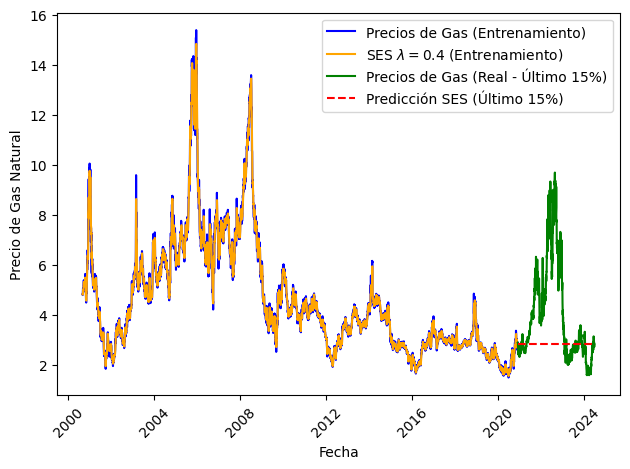

In [62]:


# Leer el archivo CSV
data = pd.read_csv(r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\Natural_Gas_data.csv")

# Imprimir las primeras filas del DataFrame y los nombres de las columnas para verificar
print(data.head())
print(data.columns)

# Convertir la columna de fecha a datetime
data['date'] = pd.to_datetime(data['date'])  # La columna se llama 'date'

# Establecer la fecha como índice
data.set_index('date', inplace=True)

# Seleccionar la columna de cierre
y = data['close'].values

# Definir la función de suavizado exponencial
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

# Configurar el parámetro de suavizado
lambda_ = 0.4

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Suavizado sobre el conjunto de entrenamiento
gas_smooth1_train = firstsmooth(y=y_train, lambda_=lambda_)

# Hacer predicciones para el último 15% (suavizado exponencial simple)
gas_smooth1_test = np.full(len(y_test), gas_smooth1_train[-1])

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - gas_smooth1_test) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, gas_smooth1_test)

# Calcular el AIC y BIC
n = len(y_test)  # Número de observaciones de prueba
k = 2  # Número de parámetros (lambda y nivel inicial)
aic_ses = n * np.log(rmse) + 2 * k
bic_ses = n * np.log(rmse) + k * np.log(n)

# Imprimir las métricas
print(f"AIC del modelo SES (lambda={lambda_}): {aic_ses}")
print(f"BIC del modelo SES (lambda={lambda_}): {bic_ses}")
print(f"MAE del modelo SES: {mae}")
print(f"RMSE del modelo SES: {rmse}")

# Graficar los datos de entrenamiento, prueba y las predicciones
plt.plot(data.index[:train_size], y_train, label='Precios de Gas (Entrenamiento)', color='blue')
plt.plot(data.index[:train_size], gas_smooth1_train, label=f'SES $\lambda={lambda_}$ (Entrenamiento)', color='orange')

# Mostrar el comportamiento real del último 15%
plt.plot(data.index[train_size:], y_test, label='Precios de Gas (Real - Último 15%)', color='green')

# Mostrar las predicciones del último 15%
plt.plot(data.index[train_size:], gas_smooth1_test, label='Predicción SES (Último 15%)', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Precio de Gas Natural')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MAE del modelo SES: 1.5182878540024465
RMSE del modelo SES: nan


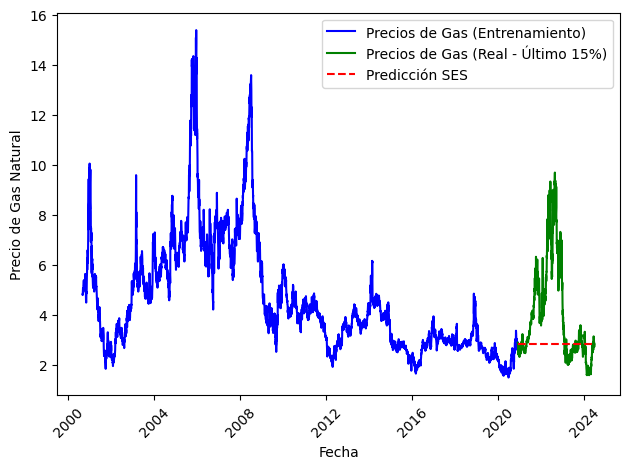

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
import joblib  # Usaremos joblib para guardar el modelo

# Leer el archivo CSV
data = pd.read_csv(r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\Natural_Gas_data.csv")

# Convertir la columna de fecha a datetime
data['date'] = pd.to_datetime(data['date'])

# Establecer la fecha como índice
data.set_index('date', inplace=True)

# Seleccionar la columna de cierre
y = data['close']

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Ajustar el modelo de suavizado exponencial simple
model = SimpleExpSmoothing(y_train).fit(smoothing_level=0.4, optimized=False)


# Hacer predicciones para el conjunto de prueba
y_pred = model.forecast(len(y_test))

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)

# Imprimir las métricas
print(f"MAE del modelo SES: {mae}")
print(f"RMSE del modelo SES: {rmse}")

# Graficar los datos de entrenamiento, prueba y las predicciones
plt.plot(y_train.index, y_train, label='Precios de Gas (Entrenamiento)', color='blue')
plt.plot(y_test.index, y_test, label='Precios de Gas (Real - Último 15%)', color='green')
plt.plot(y_test.index, y_pred, label='Predicción SES', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Precio de Gas Natural')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MAE del modelo de media móvil: 1.5031494229932292
RMSE del modelo de media móvil: 2.2358551848867134


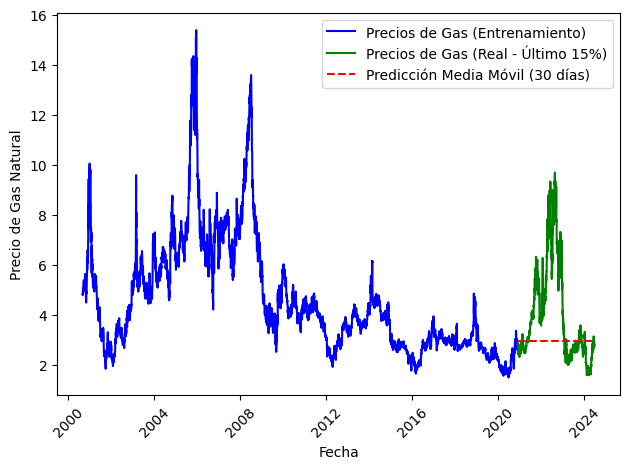

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Leer el archivo CSV
data = pd.read_csv(r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\Natural_Gas_data.csv")

# Convertir la columna de fecha a datetime
data['date'] = pd.to_datetime(data['date'])

# Establecer la fecha como índice
data.set_index('date', inplace=True)

# Seleccionar la columna de cierre
y = data['close']

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Calcular la media móvil de 30 días
rolling_mean = y_train.rolling(window=30).mean()

# Hacer predicciones para el conjunto de prueba
# Usamos el último valor de la media móvil para predecir los próximos valores
predictions = rolling_mean[-1]  # Última media móvil calculada

# Crear un array con las predicciones del tamaño de y_test
y_pred = np.full(len(y_test), predictions)

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)

# Imprimir las métricas
print(f"MAE del modelo de media móvil: {mae}")
print(f"RMSE del modelo de media móvil: {rmse}")

# Graficar los datos de entrenamiento, prueba y las predicciones
plt.plot(y_train.index, y_train, label='Precios de Gas (Entrenamiento)', color='blue')
plt.plot(y_test.index, y_test, label='Precios de Gas (Real - Último 15%)', color='green')
plt.plot(y_test.index, y_pred, label='Predicción Media Móvil (30 días)', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Precio de Gas Natural')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


MAE del modelo de media móvil: 1.5031494229932292
RMSE del modelo de media móvil: 2.2358551848867134


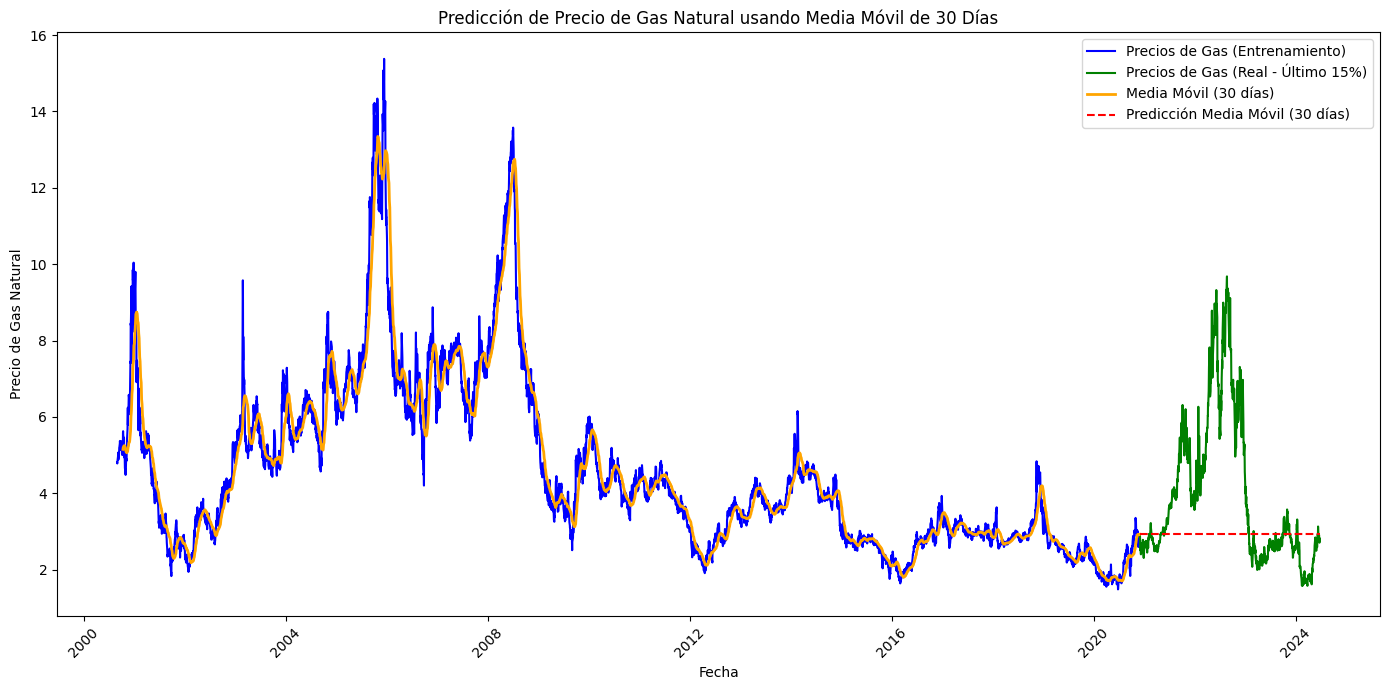

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Leer el archivo CSV
data = pd.read_csv(r"C:\Users\claud\OneDrive - Universidad del Norte\Escritorio\Series de tiempo\Natural_Gas_data.csv")

# Convertir la columna de fecha a datetime
data['date'] = pd.to_datetime(data['date'])

# Establecer la fecha como índice
data.set_index('date', inplace=True)

# Seleccionar la columna de cierre
y = data['close']

# Calcular el índice de división (85% para entrenar, 15% para predecir)
train_size = int(len(y) * 0.85)

# Dividir los datos en entrenamiento y prueba
y_train = y[:train_size]
y_test = y[train_size:]

# Calcular la media móvil de 30 días
rolling_mean = y_train.rolling(window=30).mean()

# Hacer predicciones para el conjunto de prueba
# Usamos el último valor de la media móvil para predecir los próximos valores
predictions = rolling_mean[-1]  # Última media móvil calculada

# Crear un array con las predicciones del tamaño de y_test
y_pred = np.full(len(y_test), predictions)

# Calcular el RMSE
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))

# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)

# Imprimir las métricas
print(f"MAE del modelo de media móvil: {mae}")
print(f"RMSE del modelo de media móvil: {rmse}")

# Graficar los datos de entrenamiento, prueba, la media móvil y las predicciones
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, label='Precios de Gas (Entrenamiento)', color='blue')
plt.plot(y_test.index, y_test, label='Precios de Gas (Real - Último 15%)', color='green')
plt.plot(y_train.index, rolling_mean, label='Media Móvil (30 días)', color='orange', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicción Media Móvil (30 días)', linestyle='--', color='red')

plt.xlabel('Fecha')
plt.ylabel('Precio de Gas Natural')
plt.title('Predicción de Precio de Gas Natural usando Media Móvil de 30 Días')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
